In [12]:
from scripts.mlogo import mlogo
import pandas as pd

In [13]:
# Importing input file to pandas (can also read directly from file)
file_name = "input\\cl_seqs_all.csv"
seq_file = pd.read_csv(file_name, index_col=0)

# Changing (mapping) values in the columns which group the dataset
seq_file["ab_target"] = seq_file["ab_target"].map({"sp":"Spike Positive", "sn":"Spike Negative"})
seq_file["subject_id"] = seq_file["subject_id"].apply(lambda X : f"Subject {X[-1]}")


> Dataset loaded
Plot saved as allseq_somatic_5367logo at output folder
Raw motif dataframe information saveed into motif_data folder


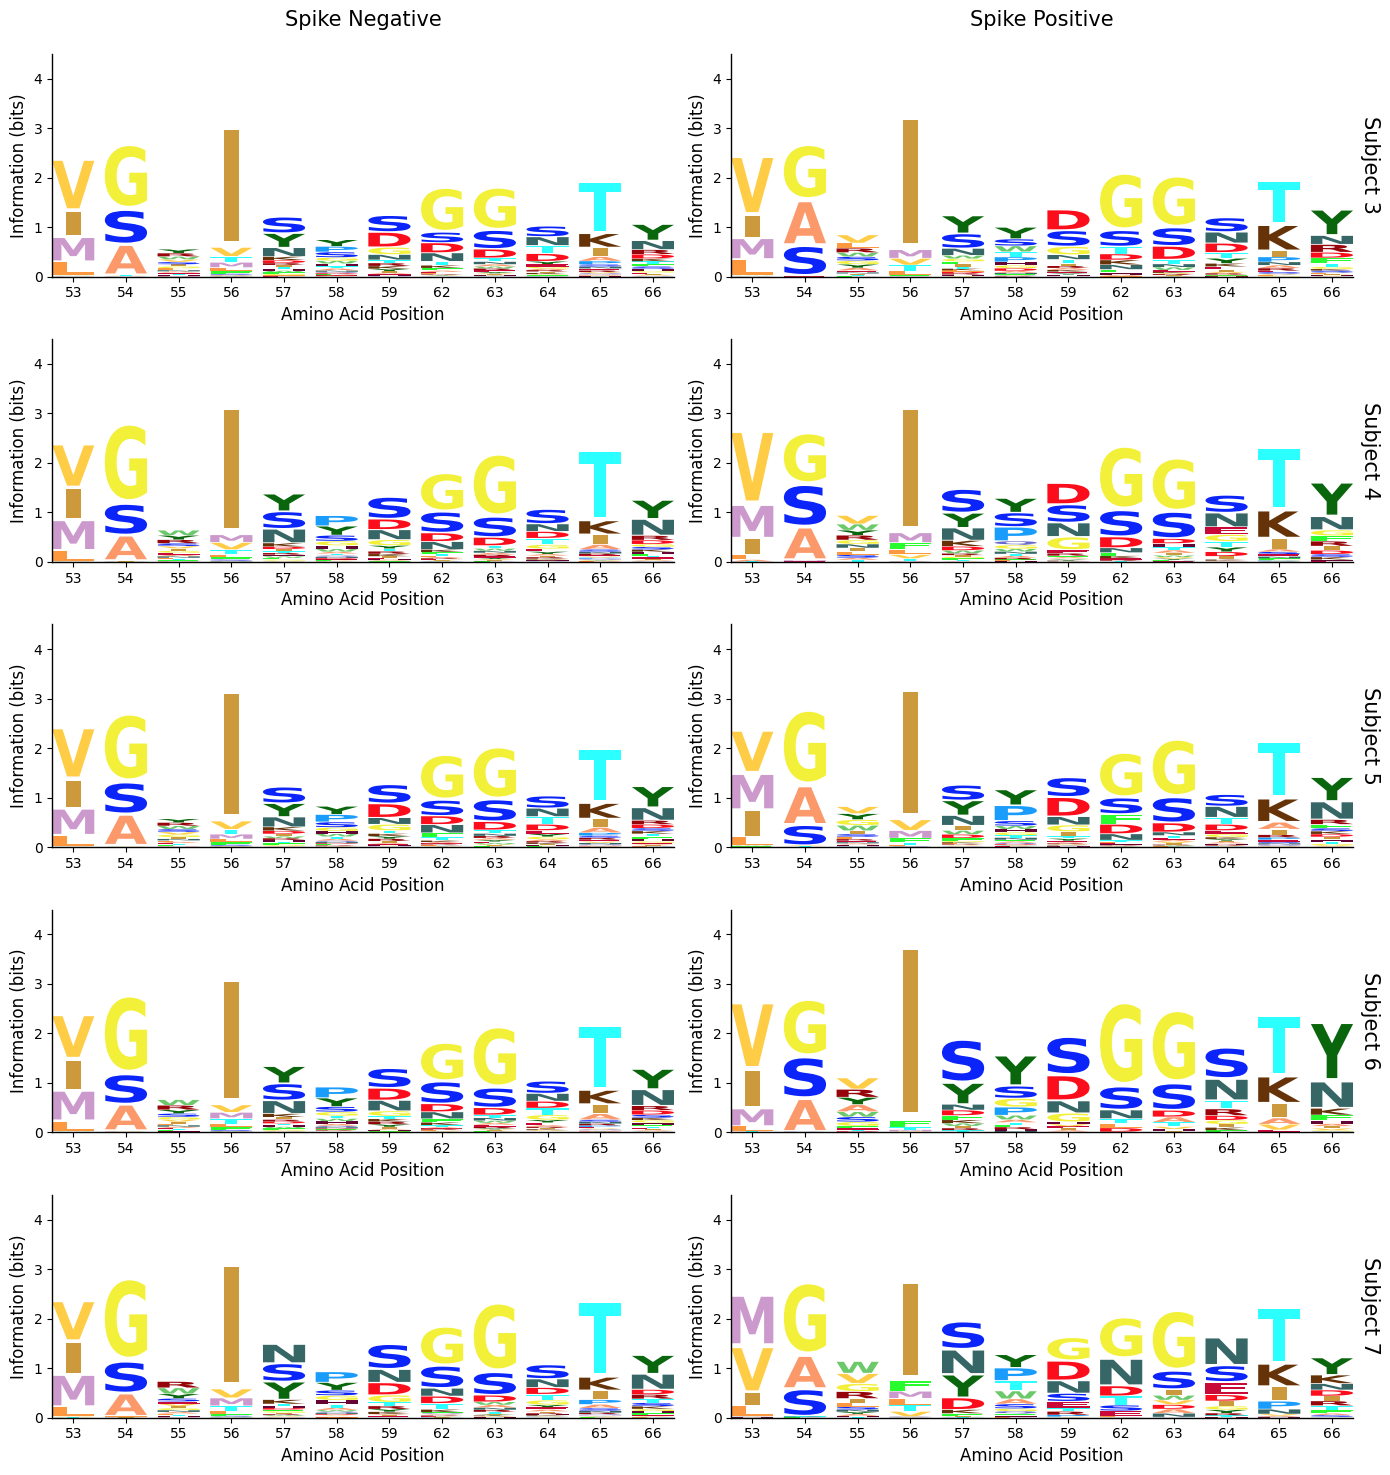

In [16]:
# Creating mlogo object (loading the data)
mlogo_obj= mlogo(seq_file, 
                 group_by="ab_target",
                 divide_subject=True)

# Creating motif plot of the wanted sequence, in this case:
# motif aa sequence (53-66): VAV ISYD..GSNK Y
seq_list = mlogo_obj.motif_logo(by="sequence",
                                aa_start=52, 
                                aa_end=66,
                                remove_pos=[60, 61],
                                yaxis_metric="information",
                                save_name= "allseq_somatic",
                                save_fig=True)